In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [3]:
data.shape

(1048575, 4)

In [5]:
data["Tag"].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

## Extract mappings required for the neural network
To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [6]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok

In [7]:
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [12]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx) 

In [13]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,19201,4
1,NaN,of,IN,O,8643,4
2,NaN,demonstrators,NNS,O,35165,4
3,NaN,have,VBP,O,25211,4
4,NaN,marched,VBN,O,21254,4


## Transform columns to extract sequential data
Next, lets fill NaN in 'sentence #' column using method ffill in fillna. Thereafter groupby on the sentence column to get a list of tokens and tags for each sentence.

In [14]:
data.isna().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
Word_idx            0
Tag_idx             0
dtype: int64

In [16]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[19201, 8643, 35165, 25211, 21254, 13758, 2395...","[4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[19799, 17758, 11157, 26784, 3487, 34061, 2097...","[14, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[2232, 16951, 28903, 33429, 16918, 4548, 23212...","[4, 4, 0, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 8, ..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[32161, 5786, 20445, 33257, 17506, 4080, 714, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[34322, 4144, 26239, 18199, 7606, 2983, 19854,...","[5, 4, 4, 9, 6, 4, 0, 4, 5, 4, 14, 4, 14, 4, 4..."


In [17]:
data_group.shape

(47959, 6)

## Pad sequences and split the dataset into train, test
Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.
Import required packages

In [23]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [24]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

In [25]:
train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [49]:
train_tokens

array([[22977, 11157, 17933, ..., 35170, 35170, 35170],
       [14419, 33508,  3748, ..., 35170, 35170, 35170],
       [ 7630,  6597, 11461, ..., 35170, 35170, 35170],
       ...,
       [23197,  6163, 23605, ..., 35170, 35170, 35170],
       [25902,   723, 21838, ..., 35170, 35170, 35170],
       [ 7630, 34058,  3165, ..., 35170, 35170, 35170]])

In [40]:
# for token, tag in zip(train_tokens[0], train_tags[0]):
#     print('%s\t%s' % (token, tag))

## Build Model Layout

Lets go through the process of building a neural network model with lstm layers. Please compare the layers brief and model plot given below to get a better understanding of the layers, input and output dimensions. We are building a simple model with 4 layers.

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal length (104) to the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions. We have chosen the n dimensions to be (64). 


These are the dimensions (?, 104, 64) plotted in the model plot for input layer and embedding layer. The ? or None in the dimension specifies batches, when it is None or ? the model can take any batch size.

- **Layer 2 - Bidirectional LSTM** : Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer (104, 64). It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The default mode is to concatenate, where the outputs are concatenated together, providing double the number of outputs to the next layer, in our case its 128(64 * 2).


The output dimension of the bidirectional lstm layer (?, 104, 128) becomes the input dimension of the next lstm layer.

- **Layer 3 - LSTM Layer** : An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.


This layer takes the output dimension from the previous bidirectional lstm layer (?, 104, 128) and outputs (?, 104, 256)



- **Layer 4 - TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence for example (a1 →b1, a2 →b2… an →bn) where a and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.



This layer take the output dimension of the previous lstm layer (104, 256) and outputs the max sequence length (104) and max tags (17).

In [26]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# import keras as k

In [27]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [28]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35172 
output_dim:  32 
input_length:  104 
n_tags:  17


In [29]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [32]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 32)           1125504   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 104, 64)           16640     
_________________________________________________________________
lstm_5 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 17)           561       
Total params: 1,155,121
Trainable params: 1,155,121
Non-trainable params: 0
_________________________________________________________________


In [33]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 512s 15s/step - loss: 0.1528 - accuracy: 0.9688 - val_loss: 0.1496 - val_accuracy: 0.9689


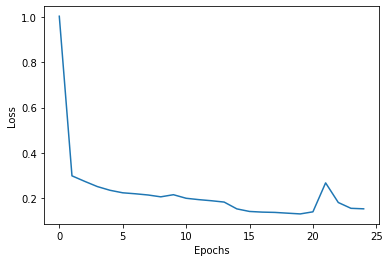

In [34]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

## Save model

In [132]:
model_bilstm_lstm.save("model.h5")

## Load model

In [134]:
from tensorflow.python.keras.models import load_model
model = load_model("model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 32)           1125504   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 104, 64)           16640     
_________________________________________________________________
lstm_5 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 17)           561       
Total params: 1,155,121
Trainable params: 1,155,121
Non-trainable params: 0
_________________________________________________________________


In [138]:
text = " ".join(data_group.iloc[2]["Word"])
text

'Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .'

In [139]:
li = text.split(" ")
len(li)

32

In [140]:
df = pd.DataFrame({"word":li})
df["word_idx"] = df["word"].map(token2idx)
df.head()

,word,word_idx
0,Helicopter,2232
1,gunships,16951
2,Saturday,28903
3,pounded,33429
4,militant,16918


In [141]:
df = df.dropna()
df["word_idx"] = df["word_idx"].astype(int)
df.head()

,word,word_idx
0,Helicopter,2232
1,gunships,16951
2,Saturday,28903
3,pounded,33429
4,militant,16918


In [142]:
my_word_idx = list(df["word_idx"])

In [143]:
score = model_bilstm_lstm.predict(my_word_idx)

In [144]:
my_li = [idx2tag[np.argmax(score[i][0])] for i in range(len(score))]

for i in range(len(my_li)):
    if my_li[i] != "O":
        print(f"{my_li[i]}: {li[i]}")

B-org: Taliban
B-geo: South


In [148]:
label_li = list(data_group.iloc[2]["Tag"])
word_li = list(data_group.iloc[2]["Word"])
for i in range(len(label_li)):
    if label_li[i] != "O":
        print(f"{label_li[i]}: {word_li[i]}")

B-tim: Saturday
B-geo: Orakzai
B-org: Taliban
B-geo: South
I-geo: Waziristan
